In [1]:
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
def koppen(P, T, lat, z = 0, Peel = True):
    
    data = pd.DataFrame(data = (P, T), index = ['P', 'T']).transpose()
    
    T = np.array(T)
    P = np.array(P)
    
    MAP = np.round(np.sum(P), 4)
    MAT = np.round(np.mean(T), 4)
    Thot = np.round(np.max(T), 4)
    Tcold = np.round(np.min(T), 4)
    Tmonth10 = np.round(sum(map(lambda x : x >= 10, T)), 4)
    Pdry = np.round(np.min(P), 4)
    
    if not Peel:
        seqT = np.array((T[0], T[1], T[2], T[3], T[4], T[5], T[6], T[7], T[8], T[9], T[10], T[11], T[0], T[1], T[2], T[3], T[4]))
        seqP = np.array((P[0], P[1], P[2], P[3], P[4], P[5], P[6], P[7], P[8], P[9], P[10], P[11], P[0], P[1], P[2], P[3], P[4]))
        data['seqT'] = np.convolve(seqT, np.ones(6, dtype=np.int), mode='valid')
        data['seqP'] = np.convolve(seqP, np.ones(6, dtype=np.int), mode='valid')
        
        s_st = data['seqT'].idxmax(axis = 1)
        s_f = s_st + 6
        w_st = s_f
        w_f = w_st + 6
        
        if s_f > 12:
            s_f = s_f - 12
        if w_f > 12:
            w_f = w_f - 12
        if s_st > 12:
            s_st = s_st - 12
        if w_st > 12:
            w_st = w_st - 12
        
        drymonth = data['P'].idxmin(axis = 1)
        season = []
        
        if s_st < s_f and w_st < w_f:
            Psdry = data['P'][(data.index >= s_st) & (data.index < s_f)].min()
            Pwdry = (data['P'][(data.index >= w_st) & (data.index < w_f)].min())
            Pswet = data['P'][(data.index >= s_st) & (data.index < s_f)].max()
            Pwwet = (data['P'][(data.index >= w_st) & (data.index < w_f)].max())
            if s_st < drymonth and s_f > drymonth:
                season.append('summer')
            else:
                season.append('winter')
        
        if s_st < s_f and w_st > w_f:
            Psdry = data['P'][(data.index >= s_st) & (data.index < s_f)].min()
            Pwdry = (data['P'][(data.index >= w_st)].min(), data['P'][(data.index < w_f)].min())
            Pwdry = np.min(Pwdry)
            Pswet = data['P'][(data.index >= s_st) & (data.index < s_f)].max()
            Pwwet = (data['P'][(data.index >= w_st)].max(), data['P'][(data.index < w_f)].max())
            Pwwet = np.max(Pwwet)
            if s_st < drymonth and s_f > drymonth:
                season.append('summer')
            else:
                season.append('winter')
        
        if s_st > s_f and w_st < w_f:
            Psdry = (data['P'][(data.index >= s_st)].min(), data['P'][(data.index < s_f)].min())
            Psdry = np.min(Psdry)
            Pwdry = (data['P'][(data.index >= w_st) & (data.index < w_f)].min())
            Pswet = (data['P'][(data.index >= s_st)].max(), data['P'][(data.index < s_f)].max())
            Pswet = np.max(Pswet)
            Pwwet = (data['P'][(data.index >= w_st) & (data.index < w_f)].max())
        
            if w_st < drymonth and w_f > drymonth:
                season.append('winter')
            else:
                season.append('summer')    
        
        if s_st < w_st:
            s_f = s_f - 1
            w_f = w_f - 1
        else:
            w_f = w_f - 1
            s_f = s_f - 1
    
        if w_st == 12:
            w_st = 0
            
        if 0.7 * MAP <= data['seqP'].loc[w_st]:
            Pthresh = 2 * MAT
        elif 0.7 * MAP <= data['seqP'].loc[s_st]:
            Pthresh = 2 * MAT + 28
        else:
            Pthresh = 2 * MAT + 14
    
    else:
        if lat > 0:
            # N
            winter = np.concatenate((P[0:3], P[9:12]))
            summer = P[3:9]
            Psdry = np.min(summer)
            Pwdry = np.min(winter)
            Pswet = np.max(summer)
            Pwwet = np.max(winter)
        else:
            #S
            winter = P[3:9]
            summer = np.concatenate((P[0:3], P[9:12]))
            Psdry = np.min(summer)
            Pwdry = np.min(winter)
            Pswet = np.max(summer)
            Pwwet = np.max(winter)
    
    if P[3:9].sum()/(MAP + 0.1) > 0.3 and  P[3:9].sum()/(MAP + 0.1) < 0.7:
        p1 = 2 * MAT + 14
    else:
        p1 = 0
    if lat < 0 or p1 != 0:
        p2 = 0
    else:
        if P[3:9].sum()/(MAP + 0.1) > 0.7:
            p2 = 2 * MAT + 28
        else:
            p2 = 2 * MAT
    if lat > 0 or p1 != 0:
        p3 = 0
    else:
        if P[3:9].sum()/(MAP + 0.1) > 0.7:
            p3 = 2 * MAT
        else:
            p3 = 2 * MAT + 28
            
    Pthresh = p1 + p2 + p3

    main_class = []

    if z >= 2300:
        if Thot >= 0:
            main_class.append('HT - Tundra')
        else:
            main_class.append('HF - Frost or Ice Cap')
    elif MAP < (10 * Pthresh):
        main_class.append('B')
    elif len(main_class) == 0 and not Tcold < 18:
        main_class.append('A')
    elif len(main_class) == 0 and Thot >= 10 and Tcold < 18 and Tcold > 0:
        main_class.append('C')
    elif len(main_class) == 0 and Thot >= 10 and Tcold <= 0:
        main_class.append('D')
    elif len(main_class) == 0 and Thot < 10:
        main_class.append('E')
    
    second_class = []
    
    if main_class[0] == 'A':
        if Pdry >= 60:
            second_class.append('f')
        else:
            if Pdry >= 100 - MAP / 25:
                second_class.append('m')
            elif Psdry < 100 - MAP / 25:
                second_class.append('s')
            elif Pwdry < 100 - MAP / 25:
                second_class.append('w')

    elif main_class[0] == 'B':
        if MAP < 5 * Pthresh:
            second_class.append('W')
        else:
            second_class.append('S')
        if MAT >= 18:
            second_class.append('h')
        else:
            second_class.append('k')

    elif main_class[0] == 'C':
        if Psdry < 40 and Psdry < Pwwet / 3:
            second_class.append('s')
        elif Pwdry < Pswet / 10:
            second_class.append('w')
        else:
            second_class.append('f')
        if Thot >= 22:
            second_class.append('a')
        elif Tmonth10 >= 4:
            second_class.append('b')
        elif 1 <= Tmonth10 and Tmonth10 < 4:
            second_class.append('c')
    
    if main_class[0] == 'D':
        if Psdry < 40 and Psdry < Pwwet / 3:
            second_class.append('s')
        elif Pwdry < Pswet / 10:
            second_class.append('w')
        else:
            second_class.append('f')
        if Thot >= 22:
            second_class.append('a')
        elif Tmonth10 >= 4:
            second_class.append('b')
        elif Tcold < -38:
            second_class.append('d')
        else:
            second_class.append('c')

    if main_class[0] == 'E':
        if Thot > 0:
            second_class.append('T')
        else:
            second_class.append('F')
    main_class = ''.join(main_class)
    second_class = ''.join(second_class)
    classification = main_class + second_class
    return classification

In [3]:
def Modality(P):
    f0 = np.zeros(len(P))
    for i in range(len(P) - 1):
        f0[i] = (P[i - 1] - P[i]) * (P[i] - P[i + 1])
        f0[0] = (P[-1] - P[0]) * (P[0] - P[1])
        f0[-1] = (P[-2] - P[-1]) * (P[-1] - P[0])
    
    def zero_runs(a):
        # Create an array that is 1 where a is 0, and pad each end with an extra 0.
        iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
        absdiff = np.abs(np.diff(iszero))
        # Runs start and end where absdiff is 1.
        ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
        return ranges
    
    f_df = pd.DataFrame(f0, columns = ['f'])

    def classify(x):
        cl = np.zeros(len(x))
        for i in range(len(x)):
            if x[i] == 0:
                cl[i] = 0
            elif x[i] > 0:
                cl[i] = 1
            else:
                cl[i] = -1
        return cl
    
    f_df =  f_df.apply(classify)
    zeros = zero_runs(f_df['f'])
    if len(zeros) > 0:
        if zeros[-1][1] == 12 and zeros[0][0] == 0:
            zeros = np.insert(zeros, 0, [zeros[-1][0], zeros[0][1]], 0)
            zeros = np.delete(zeros, 1, 0)
            zeros = np.delete(zeros, -1, 0)
    f_df['P'] = P

    mod = np.zeros(len(P))  
    for i in range(len(P)):
        if f_df['f'].iloc[i] < 0 and f_df['P'].iloc[i - 1] < f_df['P'].iloc[i]:
            mod[i] = 1
    for i in range(len(zeros) - 1):
        if P[zeros[i][0] - 1] < P[zeros[i][0]] and P[zeros[i][0] + int(np.diff(zeros[i]))] < P[zeros[i][0]]:
            mod[zeros[i][0]] = 1
    for i in range(len(zeros)):
        if zeros[-1][1] == 12:
            if P[zeros[i][0] - 1] < P[zeros[i][0]] and P[0] < P[zeros[i][0]]:
                mod[zeros[i][0]] = 1
    for i in range(len(zeros)):
        zeros[i][0] = zeros[i][0] + 1

    f_df['modality'] = mod
    peak = []
    def peaks(f_df):
        for i in range(12):
            if f_df.iloc[i]['modality'] == 1:
                peak.append(i + 1)
        return peak
    
    peaks = np.array(peaks(f_df), dtype=np.int64)
    return mod, zeros, peaks

In [4]:
def terrain(rotate, elevation):
    fig = plt.figure(figsize = (12, 8))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.gist_earth, linewidth=0.2)
    surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.gist_earth, linewidth=0.2)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.view_init(azim = rotate, elev = elevation)

<Figure size 432x288 with 0 Axes>

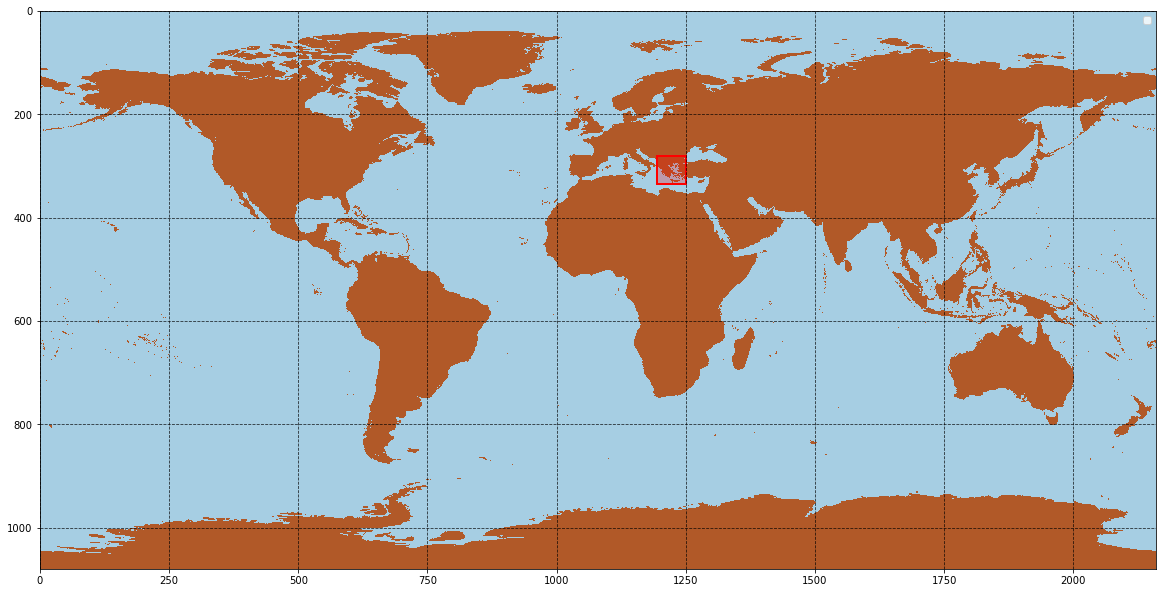

Peaks: [12]
0:01:11.795668


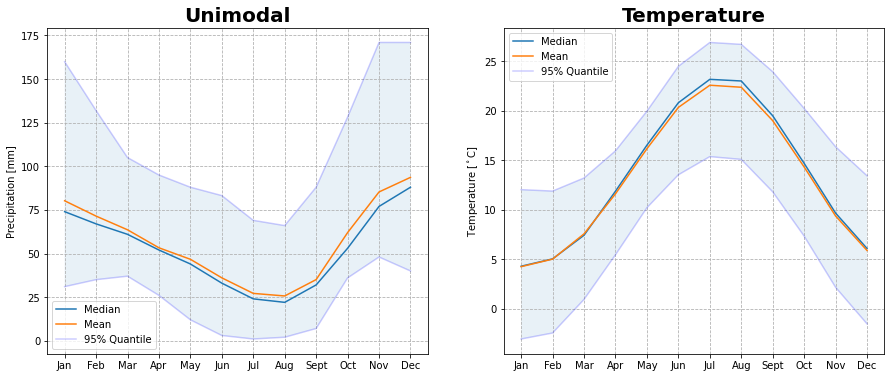

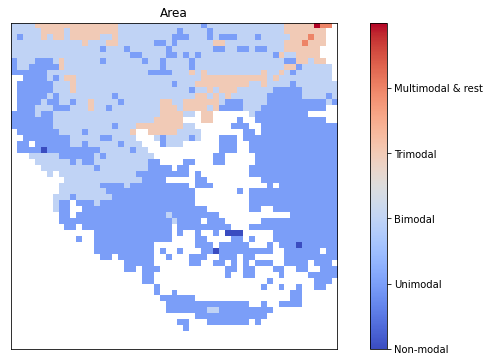

<Figure size 1800x288 with 0 Axes>

In [5]:
start_time = datetime.now()

prec1 = r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Scripts\wc2.1_10m_prec\wc2.1_10m_prec_0{}.tif'
prec2 = r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Scripts\wc2.1_10m_prec\wc2.1_10m_prec_{}.tif'
temp1 = r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Scripts\wc2.1_10m_tavg\wc2.1_10m_tavg_0{}.tif'
temp2 = r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Scripts\wc2.1_10m_tavg\wc2.1_10m_tavg_{}.tif'
elev_raster = r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Scripts\wc2.1_10m_elev\wc2.1_10m_elev.tif'
  
# m = np.random.randint(0, cols) #Lenght (Χ) 
# n = np.random.randint(0, rows) #Width  (Υ)

m = 1195      #GREECE
n = 280       #GREECE

l = 55
k = 55

#Set the new matrices
mod, flats, peak, med, med2, med3, text, w, T, kop = ([] for i in range(10))

#Raster read
for im in range(1, 10):
    w1 = (rasterio.open(prec1.format(im)))
    w.append(w1.read())
for im in range(10, 13):
    w1 = (rasterio.open(prec2.format(im)))
    w.append(w1.read())
for im in range(1, 10):
    w0 = (rasterio.open(temp1.format(im)))
    T.append(w0.read())
for im in range(10, 13):
    w0 = (rasterio.open(temp2.format(im)))
    T.append(w0.read())

elev = (rasterio.open(elev_raster)).read()

#Read shape of raster
rows = w1.shape[0]
cols = w1.shape[1]

#Get rid of Nan values
w = np.reshape(w, (12, rows, cols))
w = w.astype("float")
w[w < 0] = np.nan

T = np.reshape(T, (12, rows, cols))
T = T.astype("float")
T[T < -3e+38] = np.nan

elev = np.reshape(elev, (1, rows, cols))
elev = elev.astype("float")
elev[elev == -32768] = np.nan

plt.figure()
for i in range(int(n), int(n) + l):
     for j in range(int(m), int(m) + k):
            P = (w[0][i][j], w[1][i][j], w[2][i][j], w[3][i][j], w[4][i][j], w[5][i][j], w[6][i][j], w[7][i][j], w[8][i][j], w[9][i][j], w[10][i][j], w[11][i][j])
            T0 = (T[0][i][j], T[1][i][j], T[2][i][j], T[3][i][j], T[4][i][j], T[5][i][j], T[6][i][j], T[7][i][j], T[8][i][j], T[9][i][j], T[10][i][j], T[11][i][j])
            z = elev[0][i][j]
            med.append(P)
            med2.append(T0)
            med3.append(z)
            if w[0][i][j] >= 0:
                mod.append(sum(Modality(P)[0]))
                flats.append(Modality(P)[1])
                peak.append(Modality(P)[2])
            else:
                mod.append(np.nan)
                flats.append(np.nan)
                peak.append(np.nan)
            if T[0][i][j] >= -300:
                kop.append(koppen(P, T0, z)[0])
            else:
                kop.append(np.nan)

#World
months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec')
x = np.arange(len(months))
plt.figure(figsize = (20, 20))
mapp = w[0].astype("float")
mapp[np.isnan(mapp)] = -1
mapp[mapp >= 0] = 1
plt.imshow(mapp, cmap = 'Paired', interpolation = 'nearest')
plt.legend([(i,j)])
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((m, n), k, l, fill = None, alpha = 1, color = 'r', lw = 2))
currentAxis.add_patch(Rectangle((m, n), k, l, alpha = 0.25, color = 'r'))
plt.grid(color = 'black', ls = '--', alpha = 0.8)
plt.show();

#Stats
if not np.isnan(med).all() == True:
    array = pd.DataFrame(np.asarray(med))
    mean = np.nanmean(array, axis = 0)
    median = np.nanmedian(array, axis = 0)
    perc25 = np.nanpercentile((np.asarray(med)), 2.5, axis = 0)
    perc975 = np.nanpercentile((np.asarray(med)), 97.5, axis = 0)
    areamod, areaflat, areapeak = Modality(np.array(median));

    if not np.isnan(med2).all() == True:
        array2 = pd.DataFrame(np.asarray(med2))
        mean2 = np.nanmean(array2, axis = 0)
        median2 = np.nanmedian(array2, axis = 0)
        perc25_2 = np.nanpercentile((np.asarray(med2)), 2.5, axis = 0)
        perc975_2 = np.nanpercentile((np.asarray(med2)), 97.5, axis = 0)

    if not np.isnan(med3).all() == True:
        median3 = pd.DataFrame(np.asarray(med3))
        maxelev = np.nanmax(median3)
        minelev = np.nanmin(median3)
        median3 = np.nanmedian(median3)
        maxelev = np.nanmax(med3)

        #COOL PLOT TEMPERATURE
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax2.set_title('Temperature', fontsize=20, fontweight='bold');
        ax2.plot(x, median2);
        ax2.plot(x, mean2);
        ax2.set_ylabel('Temperature [$^\circ$C]');
        ax2.plot(months, perc25_2, color = 'blue', alpha=0.2)
        ax2.plot(months, perc975_2, color = 'blue', alpha=0.2)
        ax2.fill_between(months, perc25_2, perc975_2, alpha=0.1)
        ax2.legend(['Median', 'Mean', '95% Quantile'], loc = 'best');
        ax2.grid(ls = '--')

        if areamod.sum() == 0:
            text = 'Non-modal'
        if areamod.sum() == 1:
            text = 'Unimodal'
        if areamod.sum() == 2:
            text = 'Bimodal'
        if areamod.sum() == 3:
            text = 'Trimodal'
        if areamod.sum() > 3:
            text = 'Multimodal & rest'
        peaky = f'Peaks: {areapeak}'

        #COOL PLOT PRECIPITATION
        ax1.set_title(text, fontsize=20, fontweight='bold');
        ax1.plot(x, median);
        ax1.plot(x, mean);
        ax1.set_ylabel('Precipitation [mm]');
        ax1.plot(months, perc25, color = 'blue', alpha=0.2)
        ax1.plot(months, perc975, color = 'blue', alpha=0.2)
        ax1.fill_between(months, perc25, perc975, alpha=0.1)
        ax1.legend(['Median', 'Mean', '95% Quantile'], loc = 'best');
        ax1.grid(ls = '--')

    if areamod.any() > 0:
        print(peaky)
    if len(areaflat) > 0:
        flaty = f'Flats: {areaflat}'
        print(flaty)

    #Location
    plt.figure(figsize = (12, 6))
    plt.title('Area')
    mapping = np.reshape(mod, ((l, k)))
    colormap1 = plt.imshow(mapping, cmap='coolwarm')
    plt.grid()
    plt.xticks([])
    plt.yticks([])
    cbar2 = plt.colorbar(colormap1, shrink=1)
    cbar2.set_ticks([0, 1, 2, 3, 4])
    cbar2.set_ticklabels(['Non-modal', 'Unimodal', 'Bimodal', 'Trimodal', 'Multimodal & rest'])

    plt.figure(figsize = (25, 4))
    Koppen_map = np.reshape(kop, ((l, k)))

mapping2 = Koppen_map.copy()
mapping2[mapping2 == 'Af - Tropical Wet'] = 0
mapping2[mapping2 == 'Am - Monsoon'] = 1
mapping2[mapping2 == 'As - Summer Savannah'] = 2
mapping2[mapping2 == 'Aw - Winter Savannah'] = 3
mapping2[mapping2 == 'BWh - Hot Waste'] = 4
mapping2[mapping2 == 'BWk - Cold Waste'] = 5
mapping2[mapping2 == 'BSh - Hot Steppe'] = 6
mapping2[mapping2 == 'BSk - Cold Steppe'] = 7
mapping2[mapping2 == 'Cfa'] = 8
mapping2[mapping2 == 'Cfb'] = 9
mapping2[mapping2 == 'Cfc'] = 10
mapping2[mapping2 == 'Csa'] = 11
mapping2[mapping2 == 'Csb'] = 12
mapping2[mapping2 == 'Csc'] = 13
mapping2[mapping2 == 'Cwa'] = 14
mapping2[mapping2 == 'Cwb'] = 15
mapping2[mapping2 == 'Cwc'] = 16
mapping2[mapping2 == 'Dfa'] = 17
mapping2[mapping2 == 'Dfb'] = 18
mapping2[mapping2 == 'Dfc'] = 19
mapping2[mapping2 == 'Dfd'] = 20
mapping2[mapping2 == 'Dsa'] = 21
mapping2[mapping2 == 'Dsb'] = 22
mapping2[mapping2 == 'Dsc'] = 23
mapping2[mapping2 == 'Dsd'] = 24
mapping2[mapping2 == 'Dwa'] = 25
mapping2[mapping2 == 'Dwb'] = 26
mapping2[mapping2 == 'Dwc'] = 27
mapping2[mapping2 == 'Dwd'] = 28
mapping2[mapping2 == 'ET - Tundra'] = 29
mapping2[mapping2 == 'EF - Frost or Ice Cap'] = 30
mapping2[mapping2 == 'HT - Tundra'] = 31
mapping2[mapping2 == 'HF - Frost or Ice Cap'] = 32

#Terrain
elevation = np.reshape(med3, (l, k))
elevation[np.isnan(elevation)] = 0
data = pd.DataFrame(elevation)
df=data.unstack().reset_index()
df.columns=["X","Y","Z"]
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes

#Duration
end_time = datetime.now()
net_time = end_time - start_time
print(net_time)

In [6]:
interact(terrain, rotate = (0, 90, 10), elevation = (0, 90, 10));

interactive(children=(IntSlider(value=40, description='rotate', max=90, step=10), IntSlider(value=40, descript…